In [1]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
from declarativewidgets import channel
import declarativewidgets as decwidgets
decwidgets.init()
import os
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import pmagpy.pmagplotlib as pmagplotlib
import pandas as pd
import matplotlib.pyplot as plt#, mpld3
import numpy as np
from ipywidgets import interact, interactive, fixed
import ipywidgets
from IPython.display import display
from pmagpy.demag_gui_utilities import *
import subprocess
from hargraves_stream_utilities import *
from time import sleep
import threading
# from IPython.core import interactiveshell
%matplotlib inline

<IPython.core.display.Javascript object>

/Users/lukefairchild765/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
def set_hargraves_path(name="~/Dropbox/Hargraves_Data/"):
    global hargraves_path
    hargraves_path = name
    hargraves_path = os.path.expanduser(hargraves_path)
    return hargraves_path
set_hargraves_path();

In [4]:
%%html
<template is="urth-core-bind" channel='a'>
    <urth-core-function id="f" ref="set_hargraves_path" value="{{name}}" auto></urth-core-function>
    <label>Path to Hargraves_Data folder:</label> <input type="text" placeholder="{{name}}" value="{{name::input}}" size="35"></input><br/>
</template> 

In [5]:
%%HTML
<urth-help/>

In [ ]:
def on_name_change(old, new):
    hargraves_path = set_hargraves_path(name=new)
    msg = "{}".format(new)
    decwidgets.channel('a').set('message', msg)
    
decwidgets.channel('a').watch('name', on_name_change)

In [ ]:
%%html
<template is='urth-core-bind' channel='a' auto>
    <span>Path changed to {{message}}</span>
</template>

In [ ]:
new_meas_dir = ''
new_meas_file = ''
new_meas_log = []
loop_count=0
event = threading.Event()

In [ ]:
def get_last_file(main_path):
    global new_meas_dir
    global new_meas_file
    global new_meas_log
    global loop_count
    global event
    while True:
        event.wait(10)
        new_meas_dir = !find $main_path -type d -print0 | xargs -0 stat -f "%m %N" | sort -rn | head -1 | cut -f2- -d" "
        new_meas_dir = os.path.abspath(new_meas_dir[0])
        assert os.path.isdir(new_meas_dir), "There is something wrong with the path name {}".format(new_meas_dir)
        decwidgets.channel('c').set('counter', loop_count)
        new_meas_file = !find $new_meas_dir -name '*.rmg' -type f -print0 | xargs -0 stat -f "%m %N" | sort -rn | head -1 | cut -f2- -d" "
        new_meas_file = os.path.abspath(new_meas_file[0])
        assert os.path.isfile(new_meas_file), "There is something wrong with the path name {}".format(new_meas_file)
        new_meas_log.append([new_meas_dir, new_meas_file])
        sleep(5)
        loop_count+=1
        
        
#         return [new_meas_dir, new_meas_file]

In [ ]:
def on_loop(old,new):
    global loop_count
    return loop_count

decwidgets.channel('c').watch('counter', on_loop)

# def on_file_change(old,new):
    
    
#     test_log = open(test_log_path, 'r')
#     path_name_list = test_log.readlines()
#     test_log.close()
#     new = path_name_list[-2]+path_name_list[-1]
#     try:
#         old = path_name_list[-4]+path_name_list[-3]
#     except IndexError:
#         decwidgets.channel('b').set('update', True)
#         return True
#     if new == old:
#         decwidgets.channel('b').set('update', False)
#         return False
#     else:
#         decwidgets.channel('b').set('update', True)
#         return True

In [ ]:
timer = threading.Thread(target = get_last_file, args=[hargraves_path], name='GetHargravesFiles')
timer.start()

In [ ]:
%%html
<template is='urth-core-bind' channel='c' auto>
    <span>Loop count is {{counter}}</span>
</template>

In [ ]:
display(ipywidgets.FloatProgress(20))

In [ ]:
# %%html
# <template is='urth-core-bind' channel='b' auto>
#     <urth-core-function id="f" ref="on_file_change" result="{{update}}" auto></urth-core-function>
#     <span>UPDATE: {{update}}</span>
# </template>

In [ ]:
def start_stream():
    global stream_status
    global event
    stream_status=True
    event.set()
#     get_ipython().run_cell_magic(u'sh', u'--proc GETFILES --bg -s "$hargraves_path" "$test_log_path"', u'demag_stream.command $1 $2')
    return stream_status

In [ ]:
def shutdown_stream():
    global stream_status
    global event
    stream_status=False
    event.clear()
#     !killall bash
#     %killbgscripts
    return stream_status

In [ ]:
from declarativewidgets import channel

stream_status=False
def toggle_stream():
    global stream_status
    stream_status = not stream_status
#     if stream_status is True:
# #         channel('c').set('stream_status', True)
#         start_stream();
#     else:
    if stream_status:
        channel('c').set('stream_status', 'LIVE')
        channel('c').set('stream_clr', 'green')
    else:
        channel('c').set('stream_status', 'DEAD')
        channel('c').set('stream_clr', 'red')
#         shutdown_stream();
    if stream_status:
        return start_stream();
    else:
        return shutdown_stream();
#     return start_stream() if stream_status else shutdown_stream()
decwidgets.channel('c').watch('stream_status', toggle_stream)
decwidgets.channel('c').watch('stream_clr', toggle_stream)

In [ ]:
@interact()
def stream(Stream=True):
    return toggle_stream();

In [ ]:
%%html
<template is='urth-core-bind' channel='c' auto>
    <style>
    strong {color:{{stream_clr}};}
    </style>
    <span><strong>Stream is {{stream_status}}</strong></span>
</template>

In [ ]:
sleep(5)

In [ ]:
def find_most_recent(hargraves_path, dir_path = None):
    global new_meas_log
    path_name_list = new_meas_log
#     log = open(test_log_path, 'r')
#     path_name_list = log.readlines()
#     log.close()
    path_name = path_name_list[-1][0]
    if dir_path is None:
        dir_path = str(path_name).split('Hargraves_Data/')[1]
        file_path = path_name_list[-1][1]
    else:
        explicit_path = os.path.abspath(hargraves_path+'/'+ dir_path)
        rmg_files = !find $explicit_path -name '*.rmg'
        file_path = os.path.abspath(rmg_files[0])
    full_inp_path = os.path.abspath(hargraves_path+'/'+ dir_path + '/' + os.path.basename(dir_path) + '.inp')
    full_sam_path = os.path.abspath(hargraves_path+'/'+ dir_path + '/' + os.path.basename(dir_path) + '.sam')
#     print full_inp_path, '\nexists ---> {}'.format(os.path.isfile(full_inp_path))
#     print full_sam_path, '\nexists ---> {}'.format(os.path.isfile(full_sam_path))
    return full_inp_path, full_sam_path, file_path

In [ ]:
def get_data(hargraves_path, dir_path = None):
    global full_inp_path, full_sam_path, file_path, most_recent_sample, most_recent_samp_num, samp_list, er_specimens, er_sites, er_samples, magic_measurements, datablock, dec_geo, inc_geo, dec_tc, inc_tc 
    try:
        full_inp_path, full_sam_path, file_path = find_most_recent(hargraves_path, dir_path)
        most_recent_sample = os.path.splitext(os.path.basename(file_path))[0][:-1]
        try:
            most_recent_samp_num = most_recent_sample.split('.')[1]
        except:
            most_recent_samp_num = most_recent_sample.split('-')[1]
    except:
        return "No data detected. Turn on stream"
    _, er_specimens, er_sites, er_samples, magic_measurements = read_inp(full_inp_path,full_sam_path)
    samp_list = []
    all_samp = er_samples.er_sample_name.unique().tolist()
    try:
        for s in all_samp:
            samp_list.append(s.split('.')[1])
    except:
        for s in all_samp:
            samp_list.append(s.split('-')[1])
            
    sample_name = most_recent_sample
    specimen_name = sample_name + 'a'
    tr = magic_measurements.ix[magic_measurements.er_specimen_name==specimen_name]['treatment_temp'].tolist()
    dec = magic_measurements.ix[magic_measurements.er_specimen_name==specimen_name]['measurement_dec'].tolist()
    inc = magic_measurements.ix[magic_measurements.er_specimen_name==specimen_name]['measurement_inc'].tolist()
    moment = magic_measurements.ix[magic_measurements.er_specimen_name==specimen_name]['measurement_magn_moment'].tolist()

    datablock = map(list, zip(tr, dec, inc, moment))
    
    sample_info = er_samples.ix[er_samples['er_sample_name']==sample_name]
    sample_info.reset_index(inplace=True, drop=True)
    dec_geo, inc_geo = [], []
    dec_tc, inc_tc = [], []
    for n in range(len(dec)):
        d, i = pmag.dogeo(dec[n], inc[n], sample_info.sample_azimuth[0], sample_info.sample_dip[0])
        dec_geo.append(d)
        inc_geo.append(i)
    for n in range(len(dec_geo)):
        d, i = pmag.dotilt(dec_geo[n], inc_geo[n], sample_info.sample_bed_dip_direction[0], sample_info.sample_bed_dip[0])
        dec_tc.append(d)
        inc_tc.append(i)
    return full_inp_path, full_sam_path, file_path, most_recent_sample, most_recent_samp_num, samp_list, er_specimens, er_sites, er_samples, magic_measurements, datablock, dec_geo, inc_geo, dec_tc, inc_tc 

In [ ]:
def reload_data(dir_path = None):
    global hargraves_path
#     global full_inp_path, full_sam_path,file_path, most_recent_sample,most_recent_samp_num, samp_list, er_specimens,er_sites, er_samples, magic_measurements, datablock, dec_geo, inc_geo, dec_tc, inc_tc
#     full_inp_path, full_sam_path,file_path, most_recent_sample,most_recent_samp_num, samp_list, er_specimens,er_sites, er_samples, magic_measurements, datablock, dec_geo, inc_geo, dec_tc, inc_tc = get_data(hargraves_path, dir_path)
    return get_data(hargraves_path, dir_path)
reload_data();

In [ ]:
#@interact(sample_num = samp_list, crd=['Core', 'Geographic', 'Tilt corrected'])
# def plot_equal_area(sample_num = most_recent_samp_num, crd='Geographic'):
def plot_equal_area(sample_num, crd='Geographic'):
    sample = str(sample_num)
    if '-' in str(magic_measurements['er_specimen_name'][0]):
        sample_name = magic_measurements.er_site_name.unique()[0]+'-'+sample
    elif '.' in str(magic_measurements['er_specimen_name'][0]):
        sample_name = magic_measurements.er_site_name.unique()[0]+'.'+sample
    specimen_name = sample_name + 'a'
    tr = magic_measurements.ix[magic_measurements.er_specimen_name==specimen_name]['treatment_temp'].tolist()
    dec = magic_measurements.ix[magic_measurements.er_specimen_name==specimen_name]['measurement_dec'].tolist()
    inc = magic_measurements.ix[magic_measurements.er_specimen_name==specimen_name]['measurement_inc'].tolist()
    moment = magic_measurements.ix[magic_measurements.er_specimen_name==specimen_name]['measurement_magn_moment'].tolist()

    sample_info = er_samples.ix[er_samples['er_sample_name']==sample_name]
    sample_info.reset_index(inplace=True, drop=True)
    dec_geo, inc_geo = [], []
    dec_tc, inc_tc = [], []
    for n in range(len(dec)):
        d, i = pmag.dogeo(dec[n], inc[n], sample_info.sample_azimuth[0], sample_info.sample_dip[0])
        dec_geo.append(d)
        inc_geo.append(i)
    for n in range(len(dec_geo)):
        d, i = pmag.dotilt(dec_geo[n], inc_geo[n], sample_info.sample_bed_dip_direction[0], sample_info.sample_bed_dip[0])
        dec_tc.append(d)
        inc_tc.append(i)

    
    fig = plt.figure(figsize=(15,5))
    ax1 = plt.subplot2grid((1,3), (0,0), colspan=1)
    plt.axis("off")
    plot_net()

    if crd=='Core':
        datablock = map(list, zip(tr, dec, inc, moment))
        ipmag.plot_di(dec,inc)
    elif crd=='Geographic':
        datablock = map(list, zip(tr, dec_geo, inc_geo, moment))
        ipmag.plot_di(dec_geo, inc_geo)
    elif crd=='Tilt corrected':
        datablock = map(list, zip(tr, dec_tc, inc_tc, moment))
        ipmag.plot_di(dec_tc, inc_tc)

    ax2 = plt.subplot2grid((1,3), (0,1), colspan=1)
    plt.axis("off")
    plotZ(datablock, 90, specimen_name, 0)

    ax3 = plt.subplot2grid((1,3), (0,2), colspan=1)
    plt.axis("on")
    plotMT(datablock,specimen_name, 1, 'K',1)
    
    plt.tight_layout()
    plt.show()

In [ ]:
import traitlets

In [ ]:
full_sam_path

In [ ]:
# dirs = full_sam_path.split('/')
# for direct in range(len(dirs)):
#     if dirs[direct]=='Hargraves_Data':
#         dir_ind = direct + 1
def in_hargraves_file(value):
    global hargraves_path
    if value == 0:
        options = os.listdir(os.path.abspath(hargraves_path))
        return options
    try:
        options = os.listdir(os.path.abspath(hargraves_path+value))
        return options
    except:
        folder = !find $hargraves_path -name $value
        options = os.listdir(os.path.abspath(folder[0]))
        return options
    
def return_new_samp_list(new_dir, new_dd_list=None, return_sam_path = False):
    global hargraves_path
    global dd_list
    global samp_list
    global full_sam_path
#     path_to_load = os.path.join(hargraves_path, directory_name)
    if new_dd_list is not None:
        dd_list = new_dd_list
    path_to_load = [str(dd_list[i].value) for i in range(len(dd_list)-1)]
    path_to_load = os.path.join(hargraves_path, reduce(lambda x, y: x +'/'+ y, path_to_load)) 
    reloaded_path = !find $path_to_load -name '*.sam'
    reloaded_dir = os.path.dirname(reloaded_path[0])
#     if new_dir is not None:
#     while reloaded_dir != dd_list:
#         dd_list = dd_list[:-1]
        
    if not os.path.isdir(reloaded_dir):
        dd_list = dd_list[:-1]
        return reload_all(new_dir, dd_list)
    else:
        full_sam_path = reloaded_path[0]
        reload_data(reloaded_dir.split('Hargraves_Data/')[1])
    #     g =ipywidgets.Dropdown(options=samp_list, value=most_recent_samp_num, description="Sample")
    return samp_list
    
def reload_all(new_dir, new_dd_list=None, return_sam_path = False):
    global hargraves_path
    global dd_list
    global samp_list
    global full_sam_path
#     path_to_load = os.path.join(hargraves_path, directory_name)
    if new_dd_list is not None:
        dd_list = new_dd_list
    path_to_load = [str(dd_list[i].value) for i in range(len(dd_list)-1)]
    path_to_load = os.path.join(hargraves_path, reduce(lambda x, y: x +'/'+ y, path_to_load)) 
    reloaded_path = !find $path_to_load -name '*.sam'
    reloaded_dir = os.path.dirname(reloaded_path[0])
#     if new_dir is not None:
#     while reloaded_dir != dd_list:
#         dd_list = dd_list[:-1]
        
    if not os.path.isdir(reloaded_dir):
        dd_list = dd_list[:-1]
        return reload_all(new_dir, dd_list)
    else:
        full_sam_path = reloaded_path[0]
        reload_data(reloaded_dir.split('Hargraves_Data/')[1])
    #     g =ipywidgets.Dropdown(options=samp_list, value=most_recent_samp_num, description="Sample")
        if return_sam_path is False:
            return samp_list
        else:
            return full_sam_path

In [ ]:
def make_dropdowns(new_full_sam_path=None):
    global hargraves_path
    global full_sam_path
    global samp_list
    global most_recent_samp_num
    global dd_list
    
    if new_full_sam_path is not None and new_full_sam_path != full_sam_path:
        full_sam_path = new_full_sam_path
#     else:
# #         global dd_list, traitlet_list, g, coor
#         return dd_list, traitlet_list, g, coor
    abs_dirs = full_sam_path.split('Hargraves_Data/')[1]
    dirs = abs_dirs.split('/')
    print dirs
    dd_list = []
    for direct in range(len(dirs)-1):
        if direct==0:
            dd_list.append(ipywidgets.Dropdown(options=in_hargraves_file(0),value=dirs[direct]))
        else:
            dd_list.append(ipywidgets.Dropdown(options=in_hargraves_file(dirs[direct-1]),value=dirs[direct]))
    g =ipywidgets.Dropdown(options=samp_list, value=most_recent_samp_num, description="Sample")
    coor = ipywidgets.Dropdown(options=['Core', 'Geographic', 'Tilt corrected'], value='Geographic')
    traitlet_list = []
    for i in range(len(dd_list)-1):
        traitlet_list.append(traitlets.dlink((dd_list[i], 'value'), (dd_list[i+1], 'options'), transform=in_hargraves_file))
    traitlet_list.append(traitlets.dlink((dd_list[-1], 'value'), (g, 'options'), transform=return_new_samp_list))
    return dd_list, traitlet_list, g, coor
dd_list, traitlet_list, g, coor = make_dropdowns()
# make_dropdowns();

In [ ]:
# box_label = ipywidgets.Label('Path')
# box = ipywidgets.HBox(dd_list, description='Path')
# display(box_label)
# display(box)
# w = interactive(plot_equal_area, sample_num=g, crd=coor)
# display(w)
def close_widgets(wid_list):
    for widget in wid_list:
        widget.close()

def reload_plots(change):
    try:
        global box
        global w
        close_widgets([box,w])
    except:
        pass
    global dd_list, traitlet_list, g, coor
    new_sam_path = reload_all(None,return_sam_path=True)
#     make_dropdowns(new_sam_path)
    new_dd_list, traitlet_list, g, coor = make_dropdowns(new_sam_path)
#     box.children = dd_list
#     box.comm.notify_change({'children':tuple(dd_list)})
    box = ipywidgets.HBox(children=new_dd_list, description='Path', _fire_children_displayed=True)
#     box.children = tuple(dd_list)
    display(box)
    w = interactive(plot_equal_area, sample_num=g, crd=coor)
    display(w)
    dd_list = new_dd_list
    return new_dd_list
reload_plots(None)
#     return box
    

# dd_list[-1].observe(reload_plots, names='value')

# box.
# reload_plots(None)
# # box.observe(reload_plots,names=traitlet_list[-1])
# display(ipywidgets.HBox(children=dd_list, description='Path', name='Path'))
# box.observe(reload_plots)
# box.comm.notify_change(box.observe(reload_plots))
# box.children.observe(reload_plots)
# box.children[-1].on_submit(reload_plots)
# box.observe(reload_plots)
# traitlets.link((dd_list[-1], 'value'), (g, 'options'))

In [ ]:
def make_dropdowns(new_full_sam_path=None):
    global hargraves_path
    global full_sam_path
    global samp_list
    global most_recent_samp_num
    global dd_list
    
    if new_full_sam_path is not None and new_full_sam_path != full_sam_path:
        full_sam_path = new_full_sam_path
#     else:
# #         global dd_list, traitlet_list, g, coor
#         return dd_list, traitlet_list, g, coor
    abs_dirs = full_sam_path.split('Hargraves_Data/')[1]
    dirs = abs_dirs.split('/')
#     return dirs[:-1]
    dd_list = {}
    for direct in range(len(dirs)-1):
        if direct==0:
            dd_list['hargraves'] = in_hargraves_file(0)
        else:
            dd_list[dirs[direct-1]] = in_hargraves_file(dirs[direct-1])
    return dd_list
#     g =ipywidgets.Dropdown(options=samp_list, value=most_recent_samp_num, description="Sample")
#     coor = ipywidgets.Dropdown(options=['Core', 'Geographic', 'Tilt corrected'], value='Geographic')
#     traitlet_list = []
#     for i in range(len(dd_list)-1):
#         traitlet_list.append(traitlets.dlink((dd_list[i], 'value'), (dd_list[i+1], 'options'), transform=in_hargraves_file))
#     traitlet_list.append(traitlets.dlink((dd_list[-1], 'value'), (g, 'options'), transform=return_new_samp_list))
#     return dd_list, traitlet_list, g, coor

In [ ]:
but_list = make_dropdowns(full_sam_path)

In [ ]:
but_list

In [ ]:
%%html
<template is="urth-core-bind" channel='d'>
    <urth-core-function id="f" ref="set_hargraves_path" value="{{name}}" auto></urth-core-function>
    <label>Path to Hargraves_Data folder:</label> <input type="text" placeholder="{{name}}" value="{{name::input}}" size="35"></input><br/>
</template> 

In [ ]:
box._display_callbacks

In [ ]:
box.has_trait('children')

In [ ]:
change

In [ ]:
traitlets.HasTraits(box).observe(reset_box_children, names='children')

In [ ]:
box._display_callbacks?

In [ ]:
dd_list

In [ ]:
%%capture --no-stdout --no-display erros
updated = 0
def reset_box_children(change):
    change['old'] = change['owner'].children
    change['new'] = tuple(reload_plots(None))
    global updated
    updated = change['new']
    return change['new']
# box_comm.observe(reload_plots)
# box_child_traitlet = traitlets.dlink((box.children[1], 'change'),(box, 'children'), transform=reset_box_children)
traitlets.HasTraits(box).observe(reset_box_children, names='children')
display(box)
# site_sample_traitlet = traitlets.dlink((box.children[-1], 'value'),(w.children[0], 'options'), transform=return_new_samp_list)
interact(w)
# display(ipywidgets.HBox(children=dd_list, description='Path', name='Path'))

In [68]:
input_form = """
<div style="border:solid navy; padding:20px;">
<input type="file" id="file_selector" name="files[]" webkitdirectory directory/>
<output id="list"></output>
</div>
"""

javascript = """
<script type="text/Javascript">
  function handleFileSelect(evt) {
    var kernel = IPython.notebook.kernel;
    var files = evt.target.files; // FileList object
    console.log('Executing orig')
    console.log(files)
    // files is a FileList of File objects. List some properties.
    var output = [];
    var f = files[0]
    output.push('<li><strong>', escape(f.name), '</strong> (', f.type || 'n/a', ') - ',
                  f.size, ' bytes, last modified: ',
                  f.lastModifiedDate ? f.lastModifiedDate.toLocaleDateString() : 'n/a',
                  '</_Mli>');
    document.getElementById('list').innerHTML = '<ul>' + output.join('') + '</ul>';
    var command = 'fname = "' + f.name + '"'
    console.log(command)
    kernel.execute(command);
  }

  document.getElementById('file_selector').addEventListener('change', handleFileSelect, false);
</script>
"""

def file_selector():
    from IPython.display import HTML, display
    %cd hargraves_path
    display(HTML(input_form + javascript))
    print f.name
    return f.name

In [69]:
file_selector()

[Errno 2] No such file or directory: 'hargraves_path'
/Users/lukefairchild765/GitHub_files/Hargraves_stream


NameError: global name 'f' is not defined

In [71]:
input_form = """
<div style="border:solid navy; padding:20px;">
<input type="file" id="file_selector" name="files[]"/>
<output id="list"></output>
</div>
"""

javascript = """
<script type="text/Javascript">
  function handleFileSelect(evt) {
    var kernel = IPython.notebook.kernel;
    var files = evt.target.files; // FileList object
    console.log('Executing orig')
    console.log(files)
    // files is a FileList of File objects. List some properties.
    var output = [];
    var f = files[0]
    output.push('<li><strong>', escape(f.name), '</strong> (', f.type || 'n/a', ') - ',
                  f.size, ' bytes, last modified: ',
                  f.lastModifiedDate ? f.lastModifiedDate.toLocaleDateString() : 'n/a',
                  '</_Mli>');
    document.getElementById('list').innerHTML = '<ul>' + output.join('') + '</ul>';
    var command = 'fname = "' + f.name + '"'
    console.log(command)
    kernel.execute(command);
  }

  document.getElementById('file_selector').addEventListener('change', handleFileSelect, false);
</script>
"""

def file_selector():
    from IPython.display import HTML, display
    display(HTML(input_form + javascript))
file_selector()

In [27]:
def get_data(hargraves_path, dir_path = None):
#     global full_inp_path, full_sam_path, file_path, most_recent_sample, most_recent_samp_num, samp_list, er_specimens, er_sites, er_samples, magic_measurements, datablock, dec_geo, inc_geo, dec_tc, inc_tc 
    try:
        full_inp_path, full_sam_path, file_path = find_most_recent(hargraves_path, dir_path)
        most_recent_sample = os.path.splitext(os.path.basename(file_path))[0][:-1]
        try:
            most_recent_samp_num = most_recent_sample.split('.')[1]
        except:
            most_recent_samp_num = most_recent_sample.split('-')[1]
    except:
        pass
#         return "No data detected. Turn on stream"
    full_path = os.path.abspath(hargraves_path + '/' + dir_path)
    full_sam_path = os.path.abspath(full_path + '/' + os.path.basename(full_path) + '.sam')
    er_specimens, er_sites, er_samples, magic_measurements = read_inp(None,full_sam_path)
    samp_list = []
    all_samp = er_samples.er_sample_name.unique().tolist()
    try:
        for s in all_samp:
            samp_list.append(s.split('.')[1])
    except:
        for s in all_samp:
            samp_list.append(s.split('-')[1])
#     sample_name = er_specimens.er_specimen_name.tolist()[0]
    sample_name = str(er_specimens.er_sample_name.tolist()[0])
    specimen_name = sample_name + 'a'
#     specimen_name = str(er_specimens.er_specimen_name.tolist()[0])
    tr = magic_measurements.ix[magic_measurements.er_specimen_name==specimen_name]['treatment_temp'].tolist()
    dec = magic_measurements.ix[magic_measurements.er_specimen_name==specimen_name]['measurement_dec'].tolist()
    inc = magic_measurements.ix[magic_measurements.er_specimen_name==specimen_name]['measurement_inc'].tolist()
    moment = magic_measurements.ix[magic_measurements.er_specimen_name==specimen_name]['measurement_magn_moment'].tolist()

    datablock = map(list, zip(tr, dec, inc, moment))
    
    sample_info = er_samples.ix[er_samples['er_sample_name']==sample_name]
    sample_info.reset_index(inplace=True, drop=True)
    dec_geo, inc_geo = [], []
    dec_tc, inc_tc = [], []
    for n in range(len(dec)):
        d, i = pmag.dogeo(dec[n], inc[n], sample_info.sample_azimuth[0], sample_info.sample_dip[0])
        dec_geo.append(d)
        inc_geo.append(i)
    for n in range(len(dec_geo)):
        d, i = pmag.dotilt(dec_geo[n], inc_geo[n], sample_info.sample_bed_dip_direction[0], sample_info.sample_bed_dip[0])
        dec_tc.append(d)
        inc_tc.append(i)
    measurements = {'er_specimens':er_specimens, 'er_sites':er_sites, 
                    'er_samples':er_samples, 'magic_measurements':magic_measurements, 
                    'datablock':datablock, 'dec_geo':dec_geo, 'inc_geo':inc_geo, 
                    'dec_tc':dec_tc, 'inc_tc':inc_tc, 'samp_list':samp_list, 'dec':dec, 'inc':inc, 'treatment':tr, 'moment':moment}
    return measurements
#     return full_inp_path, full_sam_path, file_path, most_recent_sample, most_recent_samp_num, samp_list, er_specimens, er_sites, er_samples, magic_measurements, datablock, dec_geo, inc_geo, dec_tc, inc_tc 

In [28]:
# er_specimens, er_sites, er_samples, magic_measurements, datablock, dec_geo, inc_geo, dec_tc, inc_tc = 
measurements = get_data('/Users/lukefairchild765/Dropbox/Hargraves_Data/', 'Keweenawan/Gooseberry/GB1-/')

In [66]:
# @interact(data=measurements, sample_num = measurements['samp_list'], crd=['Core', 'Geographic', 'Tilt corrected'])
# g =ipywidgets.Dropdown(options=measurements['samp_list'], description="Sample")
# coor = ipywidgets.Dropdown(options=['Core', 'Geographic', 'Tilt corrected'], value='Geographic')
# @interact(sample_num=measurements['samp_list'], crd=['Core', 'Geographic', 'Tilt corrected'])
def plot_equal_area(sample_num=1,crd='Geographic'):
#     sample_num =ipywidgets.Dropdown(options=data['samp_list'], description="Sample").get_state()['value']
#     crd = ipywidgets.Dropdown(options=['Core', 'Geographic', 'Tilt corrected'], value='Geographic')
#     display(sample_num)
#     display(crd)
    global measurements
    data = measurements
    magic_measurements = data['magic_measurements']
    er_samples = data['er_samples']
    er_sites = data['er_sites']
    er_specimens = data['er_specimens']
    dec = data['dec']
    inc = data['inc']
    dec_geo = data['dec_geo']
    inc_geo = data['inc_geo']
    dec_tc = data['dec_tc']
    inc_tc = data['inc_tc']
    tr = data['treatment']
    moment = data['moment']
    
    sample = str(sample_num)
    if '-' in str(magic_measurements['er_specimen_name'][0]):
        sample_name = magic_measurements.er_site_name.unique()[0]+'-'+sample
    elif '.' in str(magic_measurements['er_specimen_name'][0]):
        sample_name = magic_measurements.er_site_name.unique()[0]+'.'+sample
    specimen_name = sample_name + 'a'
#     tr = magic_measurements.ix[magic_measurements.er_specimen_name==specimen_name]['treatment_temp'].tolist()
#     dec = magic_measurements.ix[magic_measurements.er_specimen_name==specimen_name]['measurement_dec'].tolist()
#     inc = magic_measurements.ix[magic_measurements.er_specimen_name==specimen_name]['measurement_inc'].tolist()
#     moment = magic_measurements.ix[magic_measurements.er_specimen_name==specimen_name]['measurement_magn_moment'].tolist()

#     sample_info = er_samples.ix[er_samples['er_sample_name']==sample_name]
#     sample_info.reset_index(inplace=True, drop=True)
#     dec_geo, inc_geo = [], []
#     dec_tc, inc_tc = [], []
#     for n in range(len(dec)):
#         d, i = pmag.dogeo(dec[n], inc[n], sample_info.sample_azimuth[0], sample_info.sample_dip[0])
#         dec_geo.append(d)
#         inc_geo.append(i)
#     for n in range(len(dec_geo)):
#         d, i = pmag.dotilt(dec_geo[n], inc_geo[n], sample_info.sample_bed_dip_direction[0], sample_info.sample_bed_dip[0])
#         dec_tc.append(d)
#         inc_tc.append(i)

    
    fig = plt.figure(figsize=(15,5))
    ax1 = plt.subplot2grid((1,3), (0,0), colspan=1)
    plt.axis("off")
    plot_net()

#     if crd.get_state()['value']=='Core':
    if crd=='Core':
        datablock = map(list, zip(tr, dec, inc, moment))
        ipmag.plot_di(dec,inc)
    elif crd =='Geographic':
        datablock = map(list, zip(tr, dec_geo, inc_geo, moment))
        ipmag.plot_di(dec_geo, inc_geo)
    elif crd=='Tilt corrected':
        datablock = map(list, zip(tr, dec_tc, inc_tc, moment))
        ipmag.plot_di(dec_tc, inc_tc)
    else:
        return 'No coordinate system selected'

    ax2 = plt.subplot2grid((1,3), (0,1), colspan=1)
    plt.axis("off")
#     print datablock
    plotZ(datablock, 90, specimen_name, 0)

    ax3 = plt.subplot2grid((1,3), (0,2), colspan=1)
    plt.axis("on")
    plotMT(datablock,specimen_name, 1, 'K',1)
#     return
    plt.tight_layout()
    plt.show()
    
# plot_equal_area(measurements)
# display(coor)

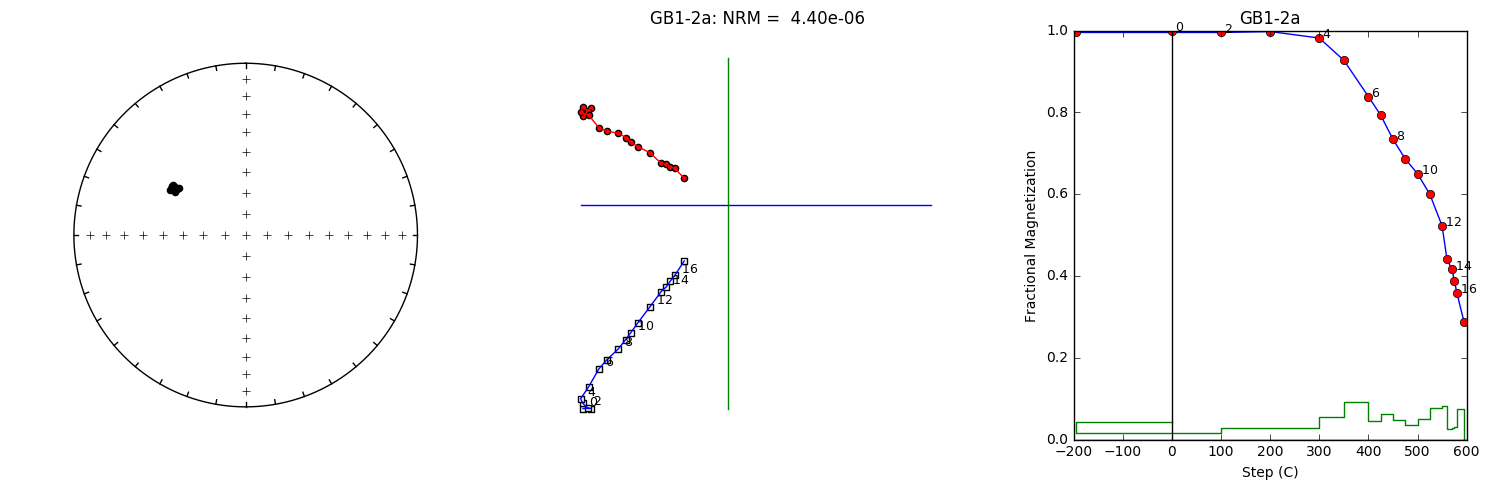

In [67]:
interactive(plot_equal_area, sample_num=measurements['samp_list'], crd=['Core', 'Geographic', 'Tilt corrected'])

In [60]:
measurements['samp_list']

['1', '2', '3', '4', '5', '6', '7', '8']

In [43]:
crd = ipywidgets.Dropdown(options=['Core', 'Geographic', 'Tilt corrected'], value='Geographic')

In [44]:
crd.add_traits.im_func

In [46]:
crd.get_state()['value']=='Geographic'

True

In [16]:
#@interact(sample_num = samp_list, crd=['Core', 'Geographic', 'Tilt corrected'])
interactive(plot_equal_area(measurements), sample_num = measurements['samp_list'], crd=['Core', 'Geographic', 'Tilt corrected'])

TypeError: 'NoneType' object is not callable

In [8]:
def shit(data, selection='0'):
    return data[int(selection)]
interact(shit(measurements['samp_list']), selection=measurements['samp_list'])

TypeError: 'str' object is not callable

<function ipywidgets.widgets.interaction.<lambda>>